# Summarize NWChem Computations
Gets a list of all of the NWChem computations that have completed and put them in a single summary document. 

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from pathlib import Path
from tqdm import tqdm
from datetime import datetime
import pandas as pd
import numpy as np
import json

## Find all of the Simulation Recorsds, Summarize them
These files contain the runtime information about 

In [2]:
records = list(Path('runs').glob('**/simulation-results.json'))
print(f'Found {len(records)} sets of simulation records')

Found 20 sets of simulation records


In [3]:
def get_run_info(record: Path):
    """Get information about the records that were run
    
    We want:
        - The computation being run: molecule name, computation type, options (e.g., charge, solvent), how many nodes
        - Output information: Did it complete successfully, how long did it take
        - Timing: When was the computation started, when did the steering app launch
        - Selection info: What was the predicted IP and uncertainty, search_space name
        - Success metrics: What are the IPs of this molecule
        
    Args:
        record: Path to the simulation records
        
    Returns:
        DataFrame of molecule information
    """
    
    # Load in the molecule records
    sim_records = pd.read_json(record, lines=True)
    task_info = pd.DataFrame(sim_records['task_info'].to_list())
    
    # Load in the environment variables
    with open(record.parent / 'environment.json') as fp:
        envs = json.load(fp)
    
    # Load in the run parameters information
    with open(record.parent / 'run_params.json') as fp:
        run_params = json.load(fp)
        
    # Get task input information
    output = task_info[['inchi', 'method']].copy()
    output['qc_nodes'] = run_params['nodes_per_task']
    output['ensemble_nodes'] = run_params['nnodes']
    
    #   Settings for the single point computations
    def _get_charge(rec):
        if rec['method'] == "compute_single_point":
            return rec['inputs'][0][1]
        return 1 if rec['method'] == 'compute_adiabatic' else 0
    output['charge'] = sim_records.apply(_get_charge, axis=1)
    output['solvent'] = sim_records.query('method=="compute_single_point"')['inputs'].apply(lambda x: None if len(x[0]) < 3 else x[0][2])
    
    # Output from the computation
    output['success'] = sim_records['success']
    output['time_running'] = sim_records['time_running']
    output['time_completed'] = sim_records['time_result_received']
    output['node_hours'] = sim_records['time_running'] * output['qc_nodes'] / 3600
    
    # Timing
    output['run_name'] = record.parent.name
    output['start_time'] = sim_records['time_created']
    with open(record.parent / 'runtime.log') as fp:
        first = datetime.strptime(fp.readline().split(" - ")[0], '%Y-%m-%d %H:%M:%S,%f')
        output['ensemble_start_time'] = first.timestamp()
    output['walltime_elapsed'] = output['time_completed'] - output['ensemble_start_time']
    output['node_hours_elapsed'] = output['walltime_elapsed'] * output['ensemble_nodes'] / 3600
    
    # Selection info
    for r in ['mean', 'std']:
        output[f'pred_ip_{r}'] = task_info[r]
    output['search_space'] = Path(run_params['search_space']).name
        
    # Success metrics
    if 'ips' in task_info:
        ips = pd.DataFrame(task_info['ips'].apply(lambda x: x if isinstance(x, dict) else {}).tolist())
        output = pd.concat((output, ips), axis=1)
    
    return output

In [4]:
all_runs = pd.concat([get_run_info(r) for r in tqdm(records)], ignore_index=True)

100%|██████████| 20/20 [00:15<00:00,  1.29it/s]


Sort in a reasonable order

In [5]:
all_runs.sort_values(['ensemble_start_time', 'time_completed'], ascending=True, inplace=True, ignore_index=True)

Compute the total elapsed walltime and node hours

In [6]:
def compute_elapsed_time(data, column): 
    """Compute the elapsed walltime across jobs
    
    Args:
        data: Dataframe to modify
        column: Name of elapsed time to consider
    """
    
    # Get the endpoint from the previous jobs
    starting_point = [0] + data.groupby('run_name')[column].max().tolist()[:-1]
    starting_point = np.cumsum(starting_point)
    
    # Add it to the appropriate rows
    to_add = np.repeat(starting_point, data.groupby('run_name').apply(len))
    return data[column] + to_add

In [7]:
all_runs['walltime_elapsed_total'] = compute_elapsed_time(all_runs, 'walltime_elapsed')

In [8]:
all_runs['node_hours_elapsed_total'] = compute_elapsed_time(all_runs, 'node_hours_elapsed')

## Computing Cost vs Task Type
So we can get good numbers to emulate with the XTB app

Get the molecules for which we have all 4 computations

In [9]:
num_run = all_runs.groupby('inchi').apply(lambda x: set(zip(x['method'], x['charge']))).apply(len)

In [10]:
all_run = set(num_run[num_run > 3].index)

adiabatic 0.7606316275441968
single_point c=0 0.062194034353971334
single_point c=1 0.1712626714074352
vertical 0.37415375622558317


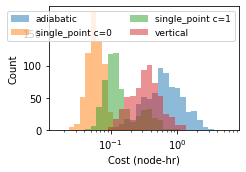

In [11]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

bins = np.logspace(-1.8, 0.8, 32)

for method, group in all_runs[all_runs.inchi.apply(lambda x: x in all_run)].query('success').groupby('method'):
    if method == 'compute_single_point':
        for charge, subgroup in group.groupby('charge'):
            ax.hist(subgroup['node_hours'], bins=bins, label=f'{method[8:]} c={charge}', alpha=0.5)
            print(f'single_point c={charge}', subgroup['node_hours'].mean())
    else:
        ax.hist(group['node_hours'], bins=bins, label=method[8:], alpha=0.5)
        print(method[8:], group['node_hours'].mean())
    
ax.set_xscale('log')

ax.set_xlabel('Cost (node-hr)')
ax.set_ylabel('Count')
ax.legend(fontsize=9, ncol=2)
fig.tight_layout()
fig.savefig('figures/runtime-by-task.png', dpi=320)

## Computing Number Found Over Time
"Time" can mean total walltime expended or nodehours burned

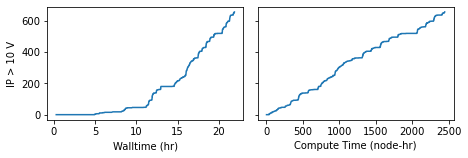

In [12]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(6.5, 2.3))

axs[0].plot(all_runs['walltime_elapsed_total'] / 3600, np.cumsum(all_runs['nob-vacuum-smb-geom'] > 10))
axs[0].set_xlabel('Walltime (hr)')

axs[1].plot(all_runs['node_hours_elapsed_total'], np.cumsum(all_runs['nob-vacuum-smb-geom'] > 10))
axs[1].set_xlabel('Compute Time (node-hr)')

axs[0].set_ylabel('IP > 10 V')

fig.tight_layout()
fig.savefig('figures/all-molecules-over-time.png', dpi=320)

## Look at the Mix of Tasks Performed
As a function of time, what fraction of each type of job did we perform

In [13]:
n_performed = dict(
    (m, np.cumsum(all_runs['method'] == m).values)
    for m in set(all_runs['method'])
)

Text(0, 0.5, 'Proportion')

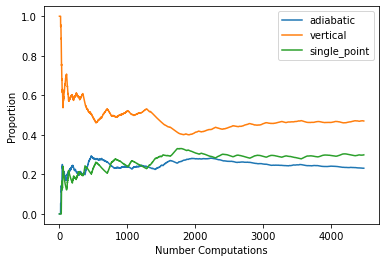

In [14]:
fig, ax = plt.subplots()

for m, counts in n_performed.items():
    ax.plot(all_runs.index, counts / (all_runs.index + 1), label=m[8:])
    
ax.legend()

ax.set_xlabel('Number Computations')
ax.set_ylabel('Proportion')

## Do we have any repeated failures?
See if I need to add logic to avoid them from being run repeatedly.

In [22]:
bad_records = []
for (inchi, method, charge), group in all_runs.query('not success').groupby(['inchi', 'method', 'charge']):
    n_failures = len(group)
    last_failure = datetime.fromtimestamp(group.query('not success')['time_completed'].max())
    eventual_success = all_runs.query(f'inchi=="{inchi}" and method=="{method}" and charge=={charge}')['success'].any()
    bad_records.append({
        'inchi': inchi,
        'method': method,
        'charge': charge,
        'n_failures': n_failures,
        'last_failure': last_failure,
        'eventual_success': eventual_success,
        'node_hours_wasted': group['node_hours'].sum()
    })
bad_records = pd.DataFrame(bad_records)

In [25]:
bad_records.query('not eventual_success').sort_values('n_failures').tail(3)

,inchi,method,charge,n_failures,last_failure,eventual_success,node_hours_wasted
80,"InChI=1S/C4H7F3/c1-3(2)4(5,6)7/h3H,1-2H3",compute_vertical,0,5,2021-10-21 08:19:23.212613,False,0.819341
87,InChI=1S/C4N4O/c5-1-3-4(2-6)8-9-7-3,compute_adiabatic,1,6,2021-10-21 08:14:35.633428,False,1.608198
100,"InChI=1S/C5H3N3/c1-5(2-6,3-7)4-8/h1H3",compute_adiabatic,1,8,2021-10-21 09:59:33.460718,False,5.789362
